In [1]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import os
import math
from sklearn import preprocessing

In [2]:
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None, n=8):
        self.transform=transform
        self.n = n
        self.root_dir = root_dir
        with open(json_path,"r") as f:
            m_idx = json.load(f)
            self.m_imgs = np.array(m_idx["im_paths"])

    def __len__(self):
        return len(self.m_imgs)

    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.root_dir, self.m_imgs[idx]))

        if self.transform:
            img = self.transform(img)

        return img

In [5]:
# def create_deep_descriptors():
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loaded device: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)

Loaded device: cpu


In [6]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=False),
    # transforms.Normalize(mean=0.5, std=0.1)
])

database = CustomDataset(root_dir="data02", json_path="data02/database/database_lite.json", transform=transform)
loader = DataLoader(database, batch_size=64)

In [8]:
# Finding global features
print("Finding centroids...")
global_features = None
for img_batch in tqdm(loader):
    img_batch = img_batch.to(device)
    with torch.no_grad():
        output = model(img_batch)
        if global_features is None:
            global_features = output.cpu().numpy().squeeze()
        else:
            global_features = np.vstack((global_features, output.cpu().numpy().squeeze()))

Finding centroids...


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/kjwdamme/opt/anaconda3/envs/FIR/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [9]:
global_features.shape

(1000, 2048)

In [10]:
np.mean(global_features), np.std(global_features)

(0.09521817, 0.1521181)

In [32]:
def cosine(map_bow_vectors, query_bow):
    cosine_sim = np.zeros(map_bow_vectors.shape[0])

    for i in range(map_bow_vectors.shape[0]):
        cosine_sim[i] = np.dot(map_bow_vectors[i], query_bow) / (np.linalg.norm(map_bow_vectors[i]) * np.linalg.norm(query_bow))

    return cosine_sim

In [33]:
def retrieve_images(map_bow_vectors, query_bow):
    # return np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))
    return np.argsort(cosine(map_bow_vectors, query_bow))

q_database = CustomDataset(root_dir="data02", json_path="data02/query/query_lite.json", transform=transform)
q_loader = DataLoader(database, batch_size=1)

# query_idx = 103
tot_corr = 0
for query_idx in range(len(q_database)):
    with torch.no_grad():
        img = q_database[query_idx].to(device)
        o = model(img[None, :])
        repr = o.cpu().numpy().squeeze()

    retrieved_images = retrieve_images(global_features, repr)

    relevant_images = np.where(sim[query_idx, :] == 1)[0]
    #
    # n_correct = len(set(retrieved_images[:10]).intersection(set(relevant_images)))
    #
    # if n_correct != 0:
    #     print('Indices of similar images retrieved: ', retrieved_images[np.argsort(retrieved_images[:10])])
    #     print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

    # print(retrieved_images[:10])
    # print(relevant_images)
    # print(f"{query_idx}: {len(set(retrieved_images[:100]).intersection(set(relevant_images)))} / {len(relevant_images)}")
    # n_correct = len(set(retrieved_images[:10]).intersection(set(relevant_images)))
    #
    # if n_correct != 0:
    #     plt.imshow(q_database[query_idx].permute(1, 2, 0))
    #     for img_idx in retrieved_images[:10]:
    #         plt.imshow(database[img_idx].permute(1, 2, 0))
    #         plt.show()
    #         if img_idx in relevant_images:
    #             print("Previous image was correctly retrieved")
    #     print("-------")


    print(f"{query_idx}: {len(set(retrieved_images[:50]).intersection(set(relevant_images)))} / {len(relevant_images)}, FOV: {fovs[query_idx, relevant_images][:5]}")

0: 0 / 1, FOV: [0.7334]
1: 0 / 2, FOV: [0.6333 0.7363]
2: 0 / 2, FOV: [0.76   0.5156]
3: 0 / 3, FOV: [0.3867 0.6904 0.4238]
4: 0 / 3, FOV: [0.5156 0.822  0.5244]
5: 0 / 3, FOV: [0.4995 0.8325 0.4766]
6: 0 / 5, FOV: [0.4592 0.4    0.3945 0.3997 0.3381]
7: 0 / 6, FOV: [0.4985 0.4365 0.432  0.4368 0.3728]
8: 0 / 7, FOV: [0.5454 0.4792 0.4756 0.4822 0.4146]
9: 0 / 8, FOV: [0.575  0.4692 0.515  0.5234 0.453 ]
10: 0 / 9, FOV: [0.53   0.4194 0.482  0.5474 0.4663]
11: 0 / 10, FOV: [0.6416 0.524  0.591  0.604  0.5273]
12: 0 / 11, FOV: [0.7246 0.643  0.6445 0.6523 0.5767]
13: 0 / 13, FOV: [0.7188 0.5938 0.672  0.712  0.632 ]
14: 0 / 14, FOV: [0.6885 0.568  0.652  0.736  0.6465]
15: 0 / 16, FOV: [0.7563 0.641  0.7305 0.8057 0.734 ]
16: 0 / 17, FOV: [0.8223 0.713  0.807  0.849  0.8003]
17: 0 / 17, FOV: [0.8564 0.852  0.855  0.8037 0.8115]
18: 0 / 17, FOV: [0.8237 0.734  0.8394 0.8677 0.8687]
19: 0 / 17, FOV: [0.8193 0.819  0.8574 0.816  0.858 ]
20: 0 / 17, FOV: [0.774  0.766  0.833  0.8125 0.8667]

In [12]:
tot_corr


32

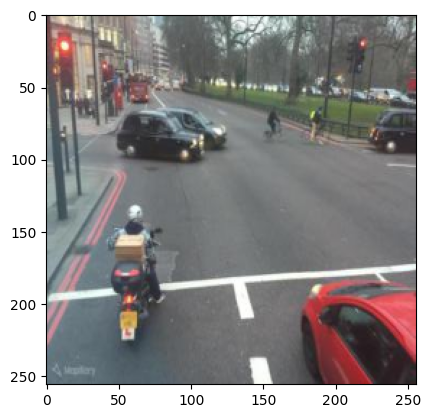

0.3752


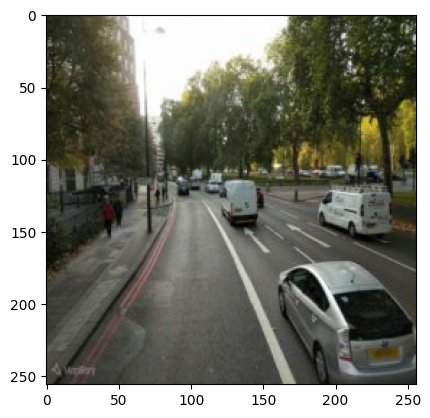

0.64


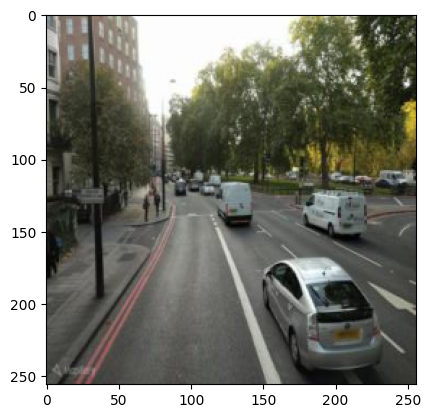

0.8545


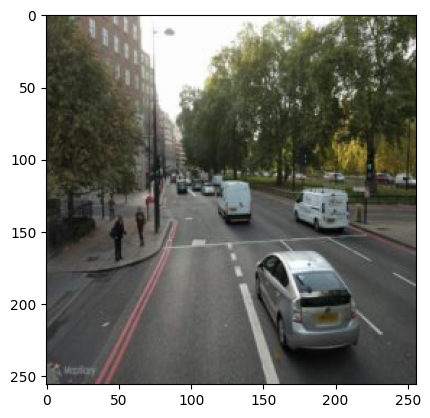

0.5415


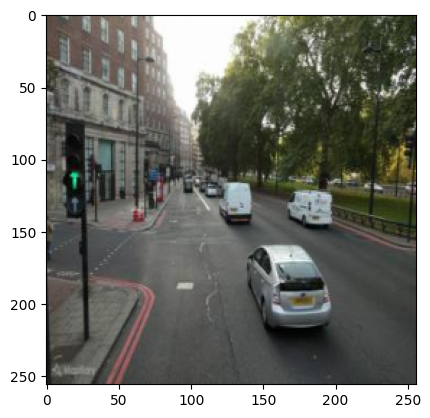

0.2847


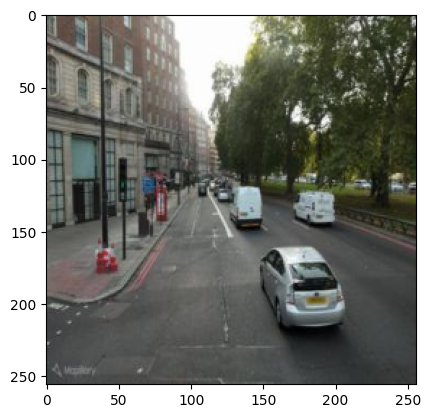

In [13]:
q_idx = 183
q = q_database[q_idx].permute(1, 2, 0)
plt.imshow(q)
plt.show()

rel_idxs = np.where(sim[q_idx, :] == 1)[0]
for rel_idx in rel_idxs:
    i = database[rel_idx].permute(1, 2, 0)
    print(fovs[q_idx, rel_idx])
    plt.imshow(i)
    plt.show()

In [34]:
## BEGIN ANSWER
def precision_at_k(relevant, retrieved, k):
    tp = np.sum(np.in1d(relevant, retrieved[:k]))
    fp = len(relevant) - tp
    return tp / (tp + fp)

In [35]:
## BEGIN ANSWER
## BEGIN ANSWER
def average_precision(relevant, retrieved):
    # BEGIN ANSWER
    precisions = []
    for k in range(len(retrieved)):
        prec_at_k = precision_at_k(relevant, retrieved, k)
        precisions.append(prec_at_k)
    return sum(precisions)/len(precisions)

def mean_average_precision(all_relevant, all_retrieved):
    # BEGIN ANSWER
    total = 0
    count = len(all_retrieved)
    for qid in range(len(all_retrieved)):
        print(all_relevant[qid])
        avg_precision = average_precision(all_relevant[qid], all_retrieved[qid])
        total += avg_precision
    # END ANSWER
    return total / count

all_relevant_images = []
all_retrieved_images = []
for query_idx in tqdm(range(len(q_database))):
    img = q_database[query_idx]

    # compute bag of words
    with torch.no_grad():
        img = q_database[query_idx].to(device)
        o = model(img[None, :])
        repr = o.cpu().numpy().squeeze()


    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    # bow = scaler.transform(bow.reshape(-1, 1).transpose())
    # bow = bow.transpose().reshape(-1)

    # Retrieve the indices of the top-10 similar images from the map
    retrieved_images = retrieve_images(global_features, repr)
#     print('Indices of similar images retrieved: ', retrieved_images[:10])
    all_retrieved_images.append(retrieved_images)
    # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
#     print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)
    all_relevant_images.append(relevant_images)

mapr = mean_average_precision(all_relevant_images, all_retrieved_images)

  0%|          | 0/500 [00:00<?, ?it/s]

[0]
[0 1]
[1 2]
[1 2 3]
[2 3 4]
[3 4 5]
[ 6  7  8  9 10]
[ 6  7  8  9 10 11]
[ 6  7  8  9 10 11 12]
[ 6  7  8  9 10 11 12 13]
[ 6  7  8  9 10 11 12 13 14]
[ 6  7  8  9 10 11 12 13 14 15]
[ 6  7  8  9 10 11 12 13 14 15 16]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6  7 

In [36]:
mapr

0.42354234739334723